# Milestone Project 2: SkimLit

The paper we're replicating (the source of the dataset) is available here: https://arxiv.org/abs/1710.06071.

The model architecture is available here: https://arxiv.org/abs/1612.05251

## Access to a GPU

In [1]:
!nvidia-smi

Sun Sep 26 16:59:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data
Let's download the dataset used in the paper (PubMed 200k RCT): https://github.com/Franck-Dernoncourt/pubmed-rct/tree/master/PubMed_200k_RCT

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# let's use the 20k dataset with numbers replaced by the at sign
import os
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data
Let's write a function to read in all of the lines of a text file

In [4]:
def get_lines(filename):
  """
  Reads filename and returns the lines of text as a list
  """
  with open(filename, "r") as f:
    return f.readlines()

In [5]:
# Read in the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Each abstract starts with a numerical ID. The idea is to represent each abstract as follows:
```
[{'line_number':0,
   'target':'BACKGROUND',
   'text': 'jdngodsgniosdng'
   'total_lines': 11},
   ...]
```
(list of dictionaries)

In [6]:
from itertools import groupby

def preprocess_text_with_line_numbers(filename):
  """
  It reads in the contents and sorts through each line, extracting for each sentence the target label, the text, how many sentences there are 
  in the current abstract and what sentence number the target line is.
  """
  input_lines = get_lines(filename)
  result = [list(g) for k,g in groupby(input_lines, lambda x: "###" in x) if not k]  #group are created based on the IDs (they start with ###)
  result = [[x for x in abstract if x != "\n"] for abstract in result] #to remove the line \n in each abstract

  abstract_samples=[] #create an empy list of abstracts 

  for abstract in result:   #result is a list of abstracts
    line_number = 0
    for line in abstract:
      line_data = {}
      target_text_split = line.split('\t')
      line_data["line_number"] = line_number
      line_data["target"] = target_text_split[0] 
      line_data["text"] = target_text_split[1].split('\n')[0].lower() #to remove the \n at the end of each sentence
      line_data['total_lines']= len(abstract) - 1 #how many total lines are there in the target abstract (start from 0)
      line_number += 1
      abstract_samples.append(line_data)
  
  return abstract_samples

In [7]:
# Get data from file and preprocess it 
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

Now that the data is in the format of a list of dictionaries, let's turn it into a DataFrame to further visualize it.

In [8]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


In [9]:
# Distribution of labels in training data
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

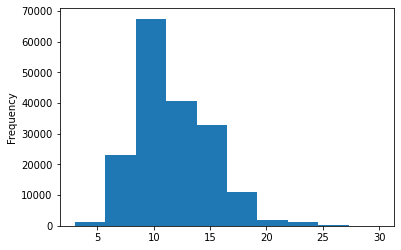

In [10]:
# Relatively to the length of each abstract (number of sentences per abstract)
train_df.total_lines.plot(kind = "hist");

### Get lists of sentences

In [11]:
## Convert abstract text lines into lists
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()


## Make numeric labels 

In [12]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)   #non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

In [13]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [14]:
# Encode labels into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [15]:
# class names from label encoder instance
class_names = label_encoder.classes_
num_classes = len(class_names)
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Defining a baseline

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
      ("tf-idf", TfidfVectorizer()),
      ("clf", MultinomialNB())
])

model_0.fit(X = train_sentences,
            y = train_labels_encoded)


Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [17]:
# Evaluate baseline model on validation set
model_0.score(val_sentences, 
              val_labels_encoded)

0.7218323844829869

In [18]:
# Defining a function to compute several metrics 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [19]:
baseline_preds = model_0.predict(val_sentences)
# baseline results
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preprocessing our data (the text) for deep sequence models

Let's create the vectorization and embedding layers.

In [20]:
import numpy as np
import tensorflow as tf

# average length of each sentence 
sentence_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sentence_lens)
avg_sent_len

26.338269273494777

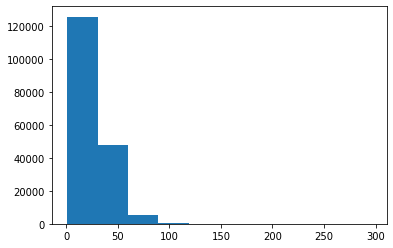

In [21]:
import matplotlib.pyplot as plt
plt.hist(sentence_lens, bins = 10);

It's better to look at the 95-th percentile:

In [22]:
output_seq_len = int(np.percentile(sentence_lens, 95))
output_seq_len 

55

(therefore 95% of sentences are under 55 tokens)

### Create text vectorizer layer
The following layer maps our text from words to numbers.

In [23]:
# vocab size (from table 2 in the paper)
max_tokens = 68000

In [24]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,    #number of words in vocab
                                    output_sequence_length=output_seq_len)    #desired output length of vectorized sequence



In [25]:
# Adapt the text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [26]:
# test out text vectorizer on random sentences
import random
sample_sentence= random.choice(train_sentences)
print(f"Original text:\n {sample_sentence}\
    \n\nVectorized version:")
text_vectorizer([sample_sentence])

Original text:
 the aim of this study was to test the effect different unstable footwear constructions have on centre of pressure motion when standing .    

Vectorized version:


<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[    2,   267,     4,    23,    17,    10,     6,   128,     2,
           70,   197,  4176,  8455, 40079,    99,    18,  1695,     4,
          200,  1322,   183,  2765,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])>

In [27]:
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(text_vocab)}")

Number of words in vocab: 64841


### Create a text embedding

In [28]:
from tensorflow import keras
token_embed = keras.layers.Embedding(input_dim = max_tokens,   #length of our vocabulary
                                   output_dim = 128,
                                   mask_zero = True, #use masking to handle variable sequence lengths (save space)
                                   name = "token_embedding")

## Creating datasets (so as to load the data as fast as possible)

We're going to be using tf.Data API. In particular we refer to: https://www.tensorflow.org/guide/data

In [29]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

( ) is the sequence varying shape, instead (5, ) is the target shape of a single sequence.

In [30]:
# Take the TensorSliceDataset and turn them into prefetched datasets 
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

Before replicating the model in the paper, let's build another model.

## Model 1: Conv1D with token embeddings

In [31]:
from tensorflow.keras import layers
# Create 1D conv model to process sequences
inputs = layers.Input(shape = (1,), dtype = "string")    #one sequence at a time
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(filters = 64, kernel_size = 5, activation = "relu", padding = "same")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) #condense the output from the conv1d layer
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [32]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8704000   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,745,349
Trainable params: 8,745,349
Non-trainable params: 0
___________________________________________________

(note that using the same padding, the conv1d layer doesn't change the first axis dimension).

In [33]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)), #to train on only the 10% of batches in each epoch (to speed up)
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)) #only validate on 10% of batches
                              )

Epoch 1/3
562/562 [==============================] - 40s 15ms/step - loss: 0.9131 - accuracy: 0.6405 - val_loss: 0.6814 - val_accuracy: 0.7380
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6551 - accuracy: 0.7583 - val_loss: 0.6293 - val_accuracy: 0.7773
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.6147 - accuracy: 0.7766 - val_loss: 0.5949 - val_accuracy: 0.7856


In [34]:
# Make predictions (the model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs.shape

(30212, 5)

In [35]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [36]:
#Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 78.77995498477426,
 'f1': 0.7853501087652804,
 'precision': 0.7846712937750364,
 'recall': 0.7877995498477426}

## Model 2: Feature extraction with pretrained token embeddings

Let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to use the later created USE pretrained embeddings.

In [37]:
# Download pretrained TensorFlow hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_sentence_encoder")

### Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow Hub

In [38]:
import tensorflow as tf 
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape = [], dtype = tf.string) #see the example in tensorflow hub
pretrained_embedding = tf_hub_embedding_layer(inputs) #tokenize text and create embedding of each sequence
x = layers.Dense(128, activation = "relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "model_2_USE_feature_extractor")

#Compile the model
model_2.compile(loss ="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [39]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [40]:
# Fit model 2
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 22ms/step - loss: 0.9167 - accuracy: 0.6482 - val_loss: 0.7938 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7671 - accuracy: 0.7015 - val_loss: 0.7530 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7509 - accuracy: 0.7120 - val_loss: 0.7374 - val_accuracy: 0.7141


In [41]:
#Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)

In [42]:
# Convert prediction probabilities to labels 
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)


## Model 3: Conv1D with character embeddings

The paper we're replicating states they used a combination of token and character-level embedding (see Figure 1, https://arxiv.org/abs/1612.05251).

The char-level embedding encodes each character (rather than 1 word) into a feature vector.

In [43]:
# Function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

#splitting non-character-level sequence into characters
split_chars(sample_sentence)

't h e   a i m   o f   t h i s   s t u d y   w a s   t o   t e s t   t h e   e f f e c t   d i f f e r e n t   u n s t a b l e   f o o t w e a r   c o n s t r u c t i o n s   h a v e   o n   c e n t r e   o f   p r e s s u r e   m o t i o n   w h e n   s t a n d i n g   .'

In [44]:
#Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [45]:
#what's the average character len
char_lens = [len(sentence) for sentence in train_sentences] #(not train_chars because it adds spaces that are considered as chars)
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

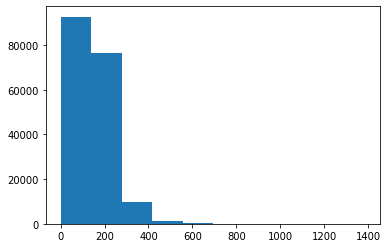

In [46]:
# Distribution of the sequences at a char-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins = 10);

In [47]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [48]:
# to define the maximum vocab size at a character level
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [49]:
# Create char-level vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 #add 2 for space and OOV token (out of vocab, '[UNK]')

char_vectorizer= TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                   output_sequence_length = output_seq_char_len,
                                   name = "char_vectorizer")

In [50]:
# Adapt it to training character
char_vectorizer.adapt(train_chars)

In [51]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']


## Creating a character-level embedding

In [52]:
char_embed = layers.Embedding(input_dim = len(char_vocab),  
                              output_dim = 25,      #size of the char embedding in the paper https://arxiv.org/pdf/1612.05251.pdf
                              mask_zero = False,
                              name = "char_embed")

### Building a Conv1D model to fit on character embeddings 

In [53]:
# Create conv1D 
inputs = layers.Input(shape = (1,), dtype = "string")    #one sequence at a time
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(filters = 64, kernel_size = 5, activation = "relu", padding = "same")(char_embeddings) #5 chars at a time may be not enough
x = layers.GlobalMaxPooling1D()(x) #condense the output from the conv1d layer
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs, outputs,
                         name = "model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [54]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
__________________________________

In [55]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [56]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 11ms/step - loss: 1.2514 - accuracy: 0.4873 - val_loss: 1.0393 - val_accuracy: 0.5785
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 1.0044 - accuracy: 0.6004 - val_loss: 0.9386 - val_accuracy: 0.6267
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9201 - accuracy: 0.6388 - val_loss: 0.8742 - val_accuracy: 0.6553


In [57]:
# Make prediction with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)

In [58]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)

In [59]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 65.70898980537535,
 'f1': 0.647401423122167,
 'precision': 0.6534548049288144,
 'recall': 0.6570898980537535}

Let's replicate the model in Figure 1 of this paper: https://arxiv.org/pdf/1612.05251.pdf.

Instead of a bi-LSTM we'll use a Dense layer.

## Model 4: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

Any engineered features used to train a model have to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings 

In [61]:
# How many different number lines are there
train_df.line_number.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

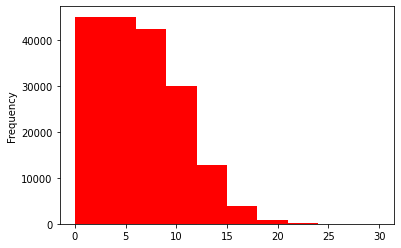

In [65]:
# check the distribution of line_number column
train_df.line_number.plot(kind = "hist", color = "r");

most abstracts have a number of lines (sentences) less than 15. Therefore, let's use 15 as the depth of the one_hot_encoder.

In [66]:
# use tf to create one-hot-encoded tensors of line_number
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)

train_line_numbers_one_hot 

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

Let's encode the total lines feature too.

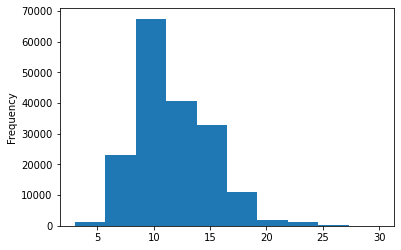

In [67]:
# Check the distribution of total lines 
train_df.total_lines.plot.hist();

In [69]:
# Check the coversage of a total_lines value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [70]:
# Create one-hot-encoded tensors of the total_lines feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20)

train_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

### Building a tribrid embedding model

1. Create a token-level model (using the pretrained embedding)
2. Create a character level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1&2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3,4,5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the triebried embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [90]:
# 1. Token inputs
token_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)   
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape = (1,), dtype = "string", name= "char_inputs" )
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Line numbers model
line_numbers_inputs = layers.Input(shape = (15,), dtype = tf.float32, name = "line_number_input")
x = layers.Dense(32, activation = "relu")(line_numbers_inputs)
line_number_model = tf.keras.Model(inputs = line_numbers_inputs, 
                                   outputs = x)

#4. Total lines model
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.float32, name = "total_lines_input")
total_lines_output = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_output)

#5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name = "char_token_hybrid_embedding")([token_model.output, char_model.output])

z = layers.Dense(256, activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

#6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name = "char_token_positional_embedding")([line_number_model.output,
                                                                                  total_lines_model.output,
                                                                                  z])
#7. Create output layer
output_layer = layers.Dense(5, activation = "softmax", name = "output_layer")(tribrid_embeddings) #n_classes = 5

#8. Model 5
model_4 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name="model_4_tribrid_embedding_model")

In [75]:
model_4.summary()

Model: "model_4_tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________

In [78]:
train_total_lines_one_hot.shape

TensorShape([180040, 20])

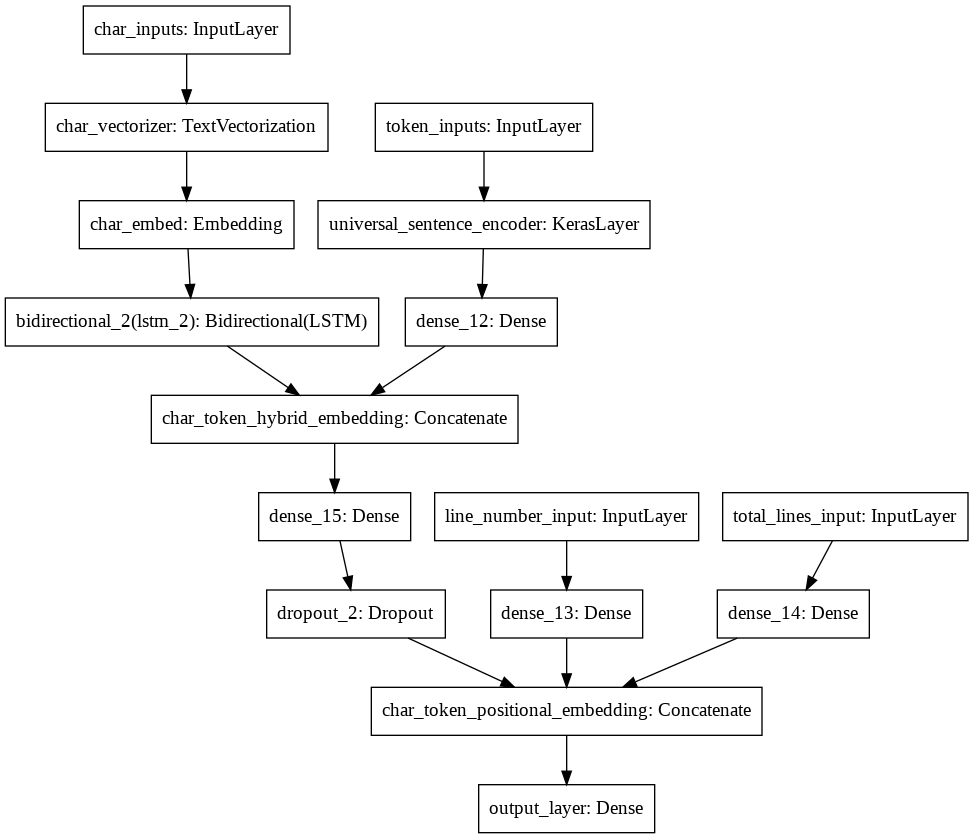

In [79]:
# Plot model 4 structure
from tensorflow.keras.utils import plot_model
plot_model(model_4)

Label smoothing

If our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes.

e.g. `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, improving generalization.

For more on label smoothing: PyImageSearch: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [91]:
# Compile token, char and positional embedding model

model_4.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

### Create tribrid embedding datasets using tf.data

(**note**: the order in tf.data.Dataset.from_tensor_slices is the same defined in the model above)

In [82]:
# Combine line numbers, total lines, chars and tokens into a dataset
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #make labels
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)


In [83]:
# Do the same for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) #make labels
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [85]:
# Check input shapes
train_char_token_pos_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

Let's define the early stopping callback

In [86]:
early_stopping_callback  = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss' , 
                                                   patience = 3, min_delta = 0.3 , verbose = 1)

In [92]:
# Fit the model 
history_model_4 = model_4.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                              epochs = 20,
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1*len(val_char_token_pos_dataset)),
                              callbacks = [early_stopping_callback])

Epoch 1/20
562/562 [==============================] - 72s 121ms/step - loss: 1.1028 - accuracy: 0.7179 - val_loss: 0.9844 - val_accuracy: 0.8022
Epoch 2/20
562/562 [==============================] - 67s 118ms/step - loss: 0.9681 - accuracy: 0.8164 - val_loss: 0.9512 - val_accuracy: 0.8298
Epoch 3/20
562/562 [==============================] - 67s 119ms/step - loss: 0.9507 - accuracy: 0.8246 - val_loss: 0.9385 - val_accuracy: 0.8328
Epoch 4/20
562/562 [==============================] - 67s 118ms/step - loss: 0.9394 - accuracy: 0.8348 - val_loss: 0.9311 - val_accuracy: 0.8341
Epoch 00004: early stopping


(note that we're fitting the model (as the previous ones) only on the 10% of the training data to speed up)

In [93]:
# Make predictions with the char token pos model
model_4_pred_probs = model_4.predict(val_char_token_pos_dataset)

In [94]:
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)

In [95]:
# Calculate results of char token pos model
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 83.54627300410434,
 'f1': 0.8298268985836754,
 'precision': 0.843458347946354,
 'recall': 0.8354627300410433}

### Make prediction on the test dataset

In [96]:
# Turn the test data samples into a tf.data.Dataset
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))

test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [97]:
# Make predictions on the test samples 
test_pred_probs = model_4.predict(test_char_token_pos_dataset)
test_preds = tf.argmax(test_pred_probs, axis = 1)

In [98]:
# Calculate results on the test set
test_results = calculate_results(test_labels_encoded, test_preds)
test_results

{'accuracy': 83.086112493778,
 'f1': 0.8254245985780688,
 'precision': 0.8371247002550017,
 'recall': 0.83086112493778}

### Finding the most wrong predictions

In [99]:
# Create DataFrame with test sentences, labels and prediction probabilities + labels
test_df = pd.DataFrame({"text":test_sentences,
                        "target":test_labels_encoded,
                        "pred":test_preds,
                        "pred_prob": tf.reduce_max(test_pred_probs, axis = 1)})
test_df.head()

,text,target,pred,pred_prob
0,this study analyzed liver function abnormaliti...,0,0,0.414365
1,a post hoc analysis was conducted with the use...,4,2,0.424368
2,liver function tests ( lfts ) were measured at...,4,2,0.813129
3,survival analyses were used to assess the asso...,4,2,0.757046
4,the percentage of patients with abnormal lfts ...,4,4,0.690837


In [100]:
# Find the wrong predictions and sort by prediction probabilities 
most_wrong_preds = test_df[test_df['target'] != test_df['pred']].sort_values("pred_prob", ascending = False)
most_wrong_preds[:10]

,text,target,pred,pred_prob
8545,pretest-posttest .,2,0,0.961465
3573,a cluster randomised trial was implemented wit...,4,2,0.944777
13874,symptom outcomes will be assessed and estimate...,1,2,0.932668
22375,patients were randomly assigned to receive eit...,4,2,0.913852
10137,this two-group online individually randomised ...,4,2,0.910232
29294,"baseline measures included sociodemographics ,...",4,2,0.908302
15697,family practices were randomly assigned to rec...,4,2,0.908202
4391,-lsb- netherlands trial register ( http://www....,1,0,0.905769
2388,the primary endpoint is the cumulative three-y...,4,2,0.905030
11814,the secondary aim was to assess onset of analg...,3,2,0.904730


In [101]:
#To recap the target labels:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Let's try the model on random examples

In [102]:
# Let's download some examples
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

--2021-09-26 17:26:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2021-09-26 17:26:08 (58.7 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



In [103]:
examples = pd.read_json("skimlit_example_abstracts.json")['abstract'].to_list()

In [104]:
import re
example_abstracts = [re.split("\.\s{1}(?=[A-Z])", sentence) for sentence in examples] #(?=) positive lookahead

Let's create a function to skim through new abstracts predicting for each sequence one of the target labels. 

In [105]:
def visualize_pred_sequence_labels(abstracts_list, model, label_encoder):
  abstract_samples=[] 
  for abstract in abstracts_list:
    line_number = 0
    for line in abstract:
      line_data = {}
      line_data["line_number"] = line_number
      line_data["text"] = line
      line_data["total_lines"]= len(abstract) - 1
      line_number += 1
      abstract_samples.append(line_data)
  
  abstracts_text = [abstract['text'] for abstract in abstract_samples]
  abstracts_chars = [split_chars(abstract) for abstract in abstracts_text]
  
  abstracts_line_numbers = [line['line_number'] for line in abstract_samples]
  abstracts_total_lines = [line['total_lines'] for line in abstract_samples]

  abstracts_line_numbers_one_hot = tf.one_hot(abstracts_line_numbers, depth = 15)
  abstracts_total_lines_one_hot = tf.one_hot(abstracts_total_lines, depth = 20)

  #Making predictions
  abstracts_pred_probs = model.predict(x = (abstracts_line_numbers_one_hot,
                                            abstracts_total_lines_one_hot,
                                            tf.constant(abstracts_text),
                                            tf.constant(abstracts_chars)))
     
  #Turning them into labels 
  abstracts_preds = tf.argmax(abstracts_pred_probs, axis=1)

  abstracts_preds_classes = [label_encoder.classes_[i] for i in abstracts_preds]
  
  for i, line in enumerate(abstracts_text):
    print(f"{abstracts_preds_classes[i]}:  {line}\n")
    if abstracts_line_numbers[i] == abstracts_total_lines[i]:   #to separate each abstract
      print("\n\n")

In [107]:
visualize_pred_sequence_labels(example_abstracts, model_4, label_encoder)

BACKGROUND:  This RCT examined the efficacy of a manualized social intervention for children with HFASDs

METHODS:  Participants were randomly assigned to treatment or wait-list conditions

METHODS:  Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language

METHODS:  A response-cost program was applied to reduce problem behaviors and foster skills acquisition

METHODS:  Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures)

METHODS:  Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents

RESULTS:  High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity

RESULTS:  Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.




BACKGROUND:  Postp